# Majority Voting Experiments

This is the default voting technique used in simple crowdsourcing systems.


## TODO
 * Aggregate over topics and repeats (50-60ish)
 * Plot multiple curves on same graph.
 * RMSE evaluation of MVNN, compared to data in paper.
 * Sort out some of the code duplication.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io
import os
import random

from sklearn.externals.joblib import Parallel, delayed

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

In [2]:
np.random.seed(0xF00F1E2)
random.seed(0xF00F1E2)

In [3]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

## Load data

In [4]:
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

In [5]:
print("{0} total useful votes, a.k.a. judgements.".format(len(judgements)))

46319 total useful votes, a.k.a. judgements.


In [6]:
DEFAULT_BUDGET = 250
COIN_FLIP = "COIN_FLIP"

# Use all cores for parallel stuff.
N_CORES = -1

In [7]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        elif vote.is_relevant == 0:
            non_relevant_votes += 1
        else:
            raise ValueError("Non 0/1 vote.")
    
    return relevant_votes, non_relevant_votes


def get_document_with_least_votes(vote_map):
    # TODO(andrei) Use heap, or even integrate in graph.
    # Sort the map by the values and return the key with the smallest value.
    return (sorted(vote_map.items(), key=lambda i: len(i[1])))[0][0]


def request_vote(topic_judgements, document_id):
    votes = topic_judgements[document_id]
    if len(votes) == 0:
        print("No votes found for document [{}].".format(document_id))
        return None
    
    vote = random.choice(votes)
    return vote

In [24]:
def full_mv_aggregation(document_id, topic_judgements):
    """Compute the voter consensus for the specified document.
    
    Calculation perform directly on all votes, without relying on any
    sampling.
    """
    
    if document_id not in topic_judgements:
        raise ValueError("Document ID#{0} doesn't have any votes to "
                         "aggregate.".format(document_id))
        
    votes = topic_judgements[document_id]
    rel_votes, non_rel_votes = count_votes(votes)

    if rel_votes == 0 and non_rel_votes == 0:
        raise ValueError("No votes for ground truth document ID#{0}. That's a "
                         "shame.".format(document_id))
        
    return rel_votes >= non_rel_votes

In [25]:
def evaluate_iteration(topic_graph, topic_judgements, ground_truth,
                       vote_aggregation, **kw):
    """ Performs a single iteration of a learning curve simulation.
    
    Please see the 'evaluate' function for more information.
    """
    
    # The votes we aggregated so far.
    # Don't keep track of anything for which we don't have the ground truth,
    # since there's no way to evaluate that.
    sampled_votes = {n.document_id: [] for n in topic_graph.nodes
                     if n.document_id in ground_truth}

    budget = kw['budget'] if 'budget' in kw else DEFAULT_BUDGET
    # How often we actually want to compute the accuracy, in terms of votes
    # sampled. We likely don't need to recompute everything after every
    # single new vote.
    accuracy_every = kw['accuracy_every'] if 'accuracy_every' in kw else 1
    
    # TODO(andrei) Numpyfy: accuracies = np.zeros(budget // accuracy_every)
    accuracies = []
    for i in range(budget):
        # 1. Pick document (with lowest number of votes)
        document_id = get_document_with_least_votes(sampled_votes)

        # 2. Request a vote for that document (sample with replacement)
        vote = request_vote(topic_judgements, document_id)
        sampled_votes[document_id].append(vote)

        if i % accuracy_every == 0:
            # 3. Perform the aggregation
            evaluated_judgements = vote_aggregation(topic_graph, sampled_votes,
                                                    **kw)

            # 4. Measure accuracy
            accuracy = measure_accuracy(evaluated_judgements, ground_truth,
                                        topic_judgements)
            accuracies.append(accuracy)
            
    return accuracies

In [26]:
def evaluate(topic_graph, topic_judgements, ground_truth, vote_aggregation,
             **kw):
    """ Evaluates a vote aggregation strategy for the specified topic.
    
    Args:
        topic_graph: The document graph of the topic on which we want to
            perform the evaluation.
        topic_judgements: The votes from which we sampled, as a map from
            document ID to a list of 'JudgementRecord's.
        ground_truth: A map of document IDs ground truth 'ExpertJudgement's.
        vote_aggregation: Function used to aggregate a document's votes and
            produce a final judgement.
            
    Returns:
        A list of learning curves. The list is 'iterations' long, and each
        learning curve is 'budget' entries long.
        
    Notes:
        TODO(andrei) Consider using loggers to control output verbosity.
        
    """
    iterations = kw['iterations'] if 'iterations' in kw else 10
    progress_every = kw['progress_every'] if 'progress_every' in kw else 50
    # verbose = kw['verbose'] if 'verbose' in kw else False
        
#     print("Performing evaluation of topic [{}].".format(topic_graph.topic))
#     print("Aggregation function: [{}]".format(vote_aggregation))
    
    all_accuracies = Parallel(n_jobs=N_CORES)(
        delayed(evaluate_iteration)(topic_graph, topic_judgements, ground_truth, vote_aggregation, **kw) 
        for idx in range(iterations))

    return all_accuracies

## Majority Voting Aggregation

In [27]:
def aggregate_MV(topic_graph, all_sampled_votes, **kw):
    """The default way of aggregating crowdsourcing votes.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        all_sampled_votes: A map from document ID to a list of
            'JudgementRecord's which have been sampled so far in our
            simulation.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
       
    return {document_id: majority(document_votes)
            for (document_id, document_votes) in all_sampled_votes.items()}
            
    
def majority(votes, tie_handling=COIN_FLIP):
    """Computes the majority of a list of 'JudgementRecord's.
    
    Args:
        votes: A list of 'JudgementRecord' objects.
        tie_handling: An enum specifying how ties are to be treated.
    
    Returns:
        A boolean indicating whether the consensus is "relevant".
        Ties are broken as specified by the 'tie_handling' parameter.
        
    """
    # Note: mind the Nones!
    relevant = len([vote for vote in votes if vote.is_relevant == True])
    non_relevant = len([vote for vote in votes if vote.is_relevant == False])
    
    if relevant > non_relevant:
         return True
    elif relevant < non_relevant:
         return False
    elif tie_handling == COIN_FLIP:
        return random.choice([True, False])
    else:
        raise ValueError("Unknown tie handling technique: [{}]."
                         .format(tie_handling))

## MV with Nearest Neighbor

* for all $i \in I$ (documents) do
    * if $i$ has no votes
        * $\hat{p_i} \leftarrow 0.5$
    * else
        * if $\rho(d_i, d_{o^i(2)}) > \rho_s$ then
            * $\hat{p_i} \leftarrow \overline{V_i \cup V_{o^i(2)}}$
        * else
            * $\hat{p_i} \leftarrow \overline{V_i}$
        * end if
    * end if
* end for

In [28]:
def aggregate_MV_NN(topic_graph, all_sampled_votes, **kw):
    """Majority voting which tries to steal votes from the closest neighbor.
    
    This method is similar to 'aggregate_MV', but also tries to take some
    document similarity information into account.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        all_sampled_votes: A map from document ID to a list of sampled
            'JudgementRecord's.
        rho_s: The similarity threshold below which we ignore the nearest
            neighbor.
        seek_good_neighbor: Enables a more thorough nearest neighbor search,
            not stopping at the very first neighbor, but at the nearest
            neighbor which also has at least 'min_votes' votes.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
    
    rho_s = kw.get('rho_s', 0.9)
    del kw['rho_s'] # TODO(andrei) Do this in a nicer way.
    seek_good_neighbor = kw.get('seek_good_neighbor', False)
    
    if seek_good_neighbor:
        aggregator = majority_with_nn_seek
    else:
        aggregator = majority_with_nn
        
    return {document_id: aggregator(topic_graph, document_id,
                                    document_votes, all_sampled_votes,
                                    rho_s, **kw)
            for (document_id, document_votes) in all_sampled_votes.items()}


def majority_with_nn(topic_graph, doc_id, votes, all_sampled_votes, rho_s, **kw):
    node = topic_graph.get_node(doc_id)
    
    if len(node.neighbors) == 0:
        # No neighbors in graph.
        return majority(votes)
    
    nn = node.sim_sorted_neighbors[0]
    if nn.similarity < rho_s:
        # Nearest neighbor is not near enough.
        return majority(votes)
    
    if nn.to_document_id not in all_sampled_votes:
        # Neighbor has no votes.
        # Note: The original MVNN code simply looks at the most similar
        # neighbor, and adds its votes. If it has no votes, then tough luck.
        return majority(votes)
    
    neighbor_votes = all_sampled_votes[nn.to_document_id]
    return majority(votes + neighbor_votes)


def majority_with_nn_seek(topic_graph, doc_id, votes, all_sampled_votes, rho_s,
                          **kw):
    """Seeks the nearest neighbor which also has some votes."""
    node = topic_graph.get_node(doc_id)
    min_votes = kw.get('min_votes', 1)
    
    if len(node.neighbors) == 0:
        # No neighbors in graph.
        return majority(votes)
    
    index = 0
    while index < len(node.neighbors):
        nn = node.sim_sorted_neighbors[index]
        index += 1

        if nn.similarity < rho_s:
            # Nearest neighbor is not near enough.
            continue
            
    
        if nn.to_document_id not in all_sampled_votes:
            # Neighbor has no vote data.
            continue

        neighbor_votes = all_sampled_votes[nn.to_document_id]
        if len(neighbor_votes) < min_votes:
            # Neighbor doesn't have enough votes for us to care.
            continue
        
        # Found a good neighbor. Stop the search.
        return majority(votes + neighbor_votes)
            
    # No good neighbor found.
    return majority(votes)

## Measurement Utilities

In [29]:
def measure_accuracy(evaluated_judgements, ground_truth, topic_judgements):
    """Compares a set of computed judgements with the ground truth.
    
    Returns:
        A floating point number in [0, 1] quantifying the accuracy of the
        computed judgements.
    """
    # TODO(andrei) Vectorize this computation as much as possible.
    match = 0
    fail = 0
    
    for doc_id in ground_truth:
        # TODO(andrei) Don't make it this far with shitty data. Filter useless GTs earlier on!
        # Unestabilshed relevance in ground truth.
        if ground_truth[doc_id].label < 0:
            continue
            
        gt_label = (ground_truth[doc_id].label > 0)        
        evaluated_label = evaluated_judgements[doc_id]
        if gt_label == evaluated_label:
            match += 1
        else:
            fail += 1
            
    return match / (match + fail)


def build_learning_curve(topic_id, aggregation_function, **kw):
    topic = id_topic_info[topic_id]
    graph = build_document_graph(topic, FULLTEXT_FOLDER)
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
    

    # i.e. up to target_votes votes per doc, on average.
    # TODO(andrei) Make this cleaner and more seamless.
    max_votes = kw['max_votes'] if 'max_votes' in kw else 3
    bud = len(topic_judgements) * max_votes
    acc = evaluate(
        graph,
        topic_judgements,
        topic_ground_truth,
        aggregation_function,
        budget=bud,
        **kw)

    acc = np.array(acc)
    acc_avg = np.mean(acc, axis=0)        
    return acc_avg

        
def plot_learning_curve(topic_id, aggregation, **kw):
    acc_avg = build_learning_curve(topic_id, aggregation, **kw)
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    plt.plot(np.arange(len(acc_avg)) / len(topic_judgements), acc_avg, label=kw.get('label', None), marker=kw.get('marker'))
    plt.xlabel("Mean votes per document")
    plt.ylabel("Accuracy")
    return acc_avg

In [30]:
class ExperimentConfig(object):    
    def __init__(self, vote_aggregator, name, params):
        self.vote_aggregator = vote_aggregator
        self.name = name
        self.params = params

In [31]:
# plot_mv_learning_curve('20910')
#plot_mv_learning_curve('20996', iterations=50)
#acc_avg = plot_learning_curve('20704', aggregate_MV, iterations=100, max_votes=1, label="MV")
#print(len(acc_avg))
#print(acc_avg[-1])
#plot_learning_curve('20704', aggregate_MV_NN, iterations=100, max_votes=1, rho_s=0.5, label="MVNN")
#plot_learning_curve('20704', aggregate_MV_NN, iterations=100, max_votes=1, rho_s=0.85, label="MVNN+", seek_good_neighbor=True, marker='^')

mv_config = ExperimentConfig(aggregate_MV, "MV", {})
mv_nn_config = ExperimentConfig(aggregate_MV_NN, "MVNN(0.5)", {'rho_s': 0.5})
mv_nn_09_config = ExperimentConfig(aggregate_MV_NN, "MVNN(0.9)", {'rho_s': 0.9})
mv_nn_plus = ExperimentConfig(aggregate_MV_NN, "MVNN+(0.9)", {'rho_s': 0.9, 'seek_good_neighbor': True})

def plot_topic(topic_id, experiments, max_votes, iterations):
    for cfg in experiments:
        plot_learning_curve(
            topic_id,
            cfg.vote_aggregator,
            iterations=iterations,
            max_votes=max_votes,
            label=cfg.name,
            **cfg.params)
        
    plt.legend(loc='lower right')

Iterations: 50


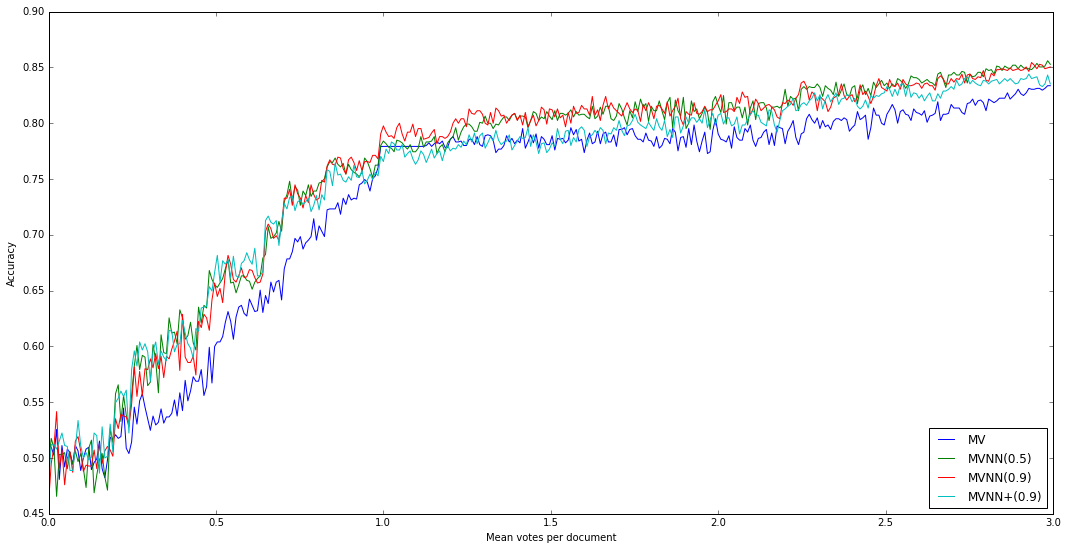

In [33]:
options={"[%s] %s (%d)" % (t.topic_id, t.query, t.document_count) : t.topic_id for t in id_topic_info.values()}

import pylab
pylab.rcParams['figure.figsize'] = (18, 9)

# MVNN+(0.9)
# See: 20584 with VERY FEW votes
# See: 20694 with VERY FEW votes
# See: 20780 with VERY FEW votes. Starts really sucking after 1.0, especially around 3.0.
# See: 20956: beats opponents 1-3
# vice president Richard Nixon seems to yield very poor results across the board.
#     Need to manually inspect data. Perhaps it's because results about Nixon 
#     as a president seem relevant but actually are not?

@interact(
    topic_id=widgets.Dropdown(options=options, value='20704'),
    iterations=widgets.IntSlider(min=10, max=5000, step=1, continuous_update=False, value=50))
def plot_proxy(topic_id, iterations):
    print("Iterations: %d" % iterations)
    plot_topic(topic_id, [mv_config, mv_nn_config, mv_nn_09_config, mv_nn_plus], 3, iterations)

In [21]:
after_one_vote = {}
topic_count = len(id_topic_info)

for i, (topic_id, topic) in enumerate(id_topic_info.items()):
    print("Topic %d/%d" % (i + 1, topic_count))
    data = build_learning_curve(
        topic_id,
        aggregate_MV,
        iterations=1000,
        max_votes=1,
        progress_every=-1)

    after_one_vote[topic_id] = data[-1]    

Topic 1/30
Topic 2/30
Topic 3/30
Topic 4/30
Topic 5/30
Topic 6/30
Topic 7/30
Topic 8/30
Topic 9/30
Topic 10/30
Topic 11/30
Topic 12/30
Topic 13/30
Topic 14/30
Topic 15/30
Topic 16/30
Topic 17/30
Topic 18/30
Topic 19/30
Topic 20/30
Topic 21/30
Topic 22/30
Topic 23/30
Topic 24/30
Topic 25/30
Topic 26/30
Topic 27/30
Topic 28/30
Topic 29/30
Topic 30/30


In [22]:
paper_standard_mv = {
    '20424': 0.594,
    '20488': 0.667,
    '20542': 0.676,
    '20584': 0.689,
    '20636': 0.716,
    '20642': 0.693,
    '20686': 0.693,
    '20690': 0.703,
    '20694': 0.726,
    '20696': 0.562,
    '20704': 0.670,
    '20714': 0.808,
    '20764': 0.676,
    '20766': 0.796,
    '20778': 0.652,
    '20780': 0.641,
    '20812': 0.688,
    '20814': 0.792,
    '20832': 0.630,
    '20910': 0.661,
    '20916': 0.650,
    '20932': 0.576,
    '20956': 0.616,
    '20958': 0.610,
    '20962': 0.552,
    '20972': 0.668,
    '20976': 0.632,
    '20996': 0.542
}

# TODO(andrei) 
paper_standard_mvnn_05 = {
    '20424': 0.608,
    '20488': 0.722,
    '20542': 0.673,
    '20584': 0.761, #*
    '20636': 0.774, #*
    '20642': 0.756, #*
    '20686': 0.639,
    
    '20690': 0.744, #*
    '20694': 0.746,
    '20696': 0.622,
    '20704': 0.790, #*
    '20714': 0.818,
    '20764': 0.600,
    '20766': 0.794,
    '20778': 0.662,
    '20780': 0.732, #*
    '20812': 0.695,
    '20814': 0.770,
    '20832': 0.642,
    '20910': 0.643,
    '20916': 0.638,
    '20932': 0.540,
    '20956': 0.646,
    '20958': 0.556,
    '20962': 0.610,
    '20972': 0.632,
    '20976': 0.620,
    '20996': 0.504
}

def rmse_own_results(own_result_map):
    rmse = 0.0
    for topic_id, mv_score in paper_standard_mv.items():
        rmse += abs(own_result_map[topic_id] - mv_score) ** 2
    
    rmse /= len(paper_standard_mv)
    return rmse

In [23]:
print(rmse_own_results(after_one_vote))

0.00980108053657


### RMSE for MV
* rmse = 0.44473 when comparing all votes to 0.0
* rmse = 0.03119 when comparing all votes to 0.5
* rmse = 0.01002 when running 500 iterations (30 Apr)
* rmse = 0.00989 when running 1000 iterations (30 Apr)